In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import json
from PIL import Image
import os
import json
import random
import cv2
import torch
import numpy as np
import json
from transformers import AutoImageProcessor, Dinov2Model
from PIL import Image
import os
from tqdm import tqdm
import torchvision.transforms as T  # First import torchvision
from segment_anything import SamPredictor, sam_model_registry
from PIL import Image
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from transformers import AutoImageProcessor, Dinov2Model
from tqdm import tqdm
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/opt/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Visualisation

/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128674 (\N{SHIP}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


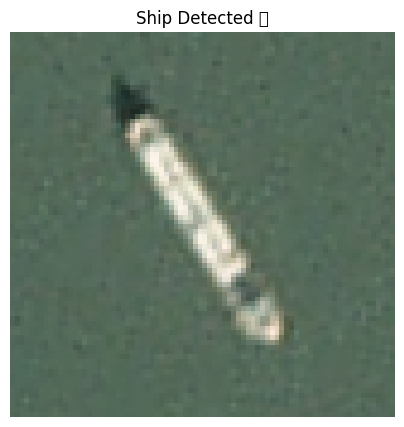

In [ ]:
# Data from kaggle: https://www.kaggle.com/datasets/rhammell/ships-in-satellite-imagery/data

# Paths
ANNOTATION_FILE = "ship_data/shipsnet.json"

# Load dataset JSON
with open(ANNOTATION_FILE, "r") as f:
    dataset = json.load(f)

# Extract images and labels
images = dataset["data"]  # List of pixel values (flattened)
labels = dataset["labels"]  # List of 0 (no-ship) or 1 (ship)

# Pick a random index with a ship
ship_indices = [i for i, label in enumerate(labels) if label == 1]
random_index = random.choice(ship_indices)

# Convert image pixel values to 80x80 RGB image
image_array = np.array(images[random_index], dtype=np.uint8)
image_array = image_array.reshape(3, 80, 80).transpose(1, 2, 0)  # Convert to (H, W, C)

# Show the image
plt.figure(figsize=(5, 5))
plt.imshow(image_array)
plt.title("Ship Detected 🚢" if labels[random_index] == 1 else "No Ship ❌")
plt.axis("off")
plt.show()


## 1st Try: Feature extraction with Dino (not pre-trained)

In [ ]:


# Load DINOv2 Model
MODEL_NAME = "facebook/dinov2-base"
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = Dinov2Model.from_pretrained(MODEL_NAME)
model.eval()  # Set to evaluation mode

# Load dataset
ANNOTATION_FILE = "ship_data/shipsnet.json"
with open(ANNOTATION_FILE, "r") as f:
    dataset = json.load(f)

images = dataset["data"]  # List of images (flattened)
labels = dataset["labels"]  # 1 = Ship, 0 = No Ship

# Store extracted features
feature_list = []
label_list = []

# Process images
for idx, image_data in tqdm(enumerate(images), total=len(images), desc="Extracting Features"):
    # Convert image pixels to 80x80 RGB image
    image_array = np.array(image_data, dtype=np.uint8).reshape(3, 80, 80).transpose(1, 2, 0)
    image = Image.fromarray(image_array)

    # Extract DINO features
    inputs = processor(image, return_tensors="pt")
    with torch.no_grad():
        features = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

    # Store features and label
    feature_list.append(features)
    label_list.append(labels[idx])

# Convert to NumPy arrays
features_np = np.array(feature_list)
labels_np = np.array(label_list)

# Save features
np.save("ship_data/dino_features.npy", features_np)
np.save("ship_data/dino_labels.npy", labels_np)

print("✅ Features extracted and saved successfully!")


Extracting Features: 100%|██████████| 4000/4000 [17:58<00:00,  3.71it/s]

✅ Features extracted and saved successfully!


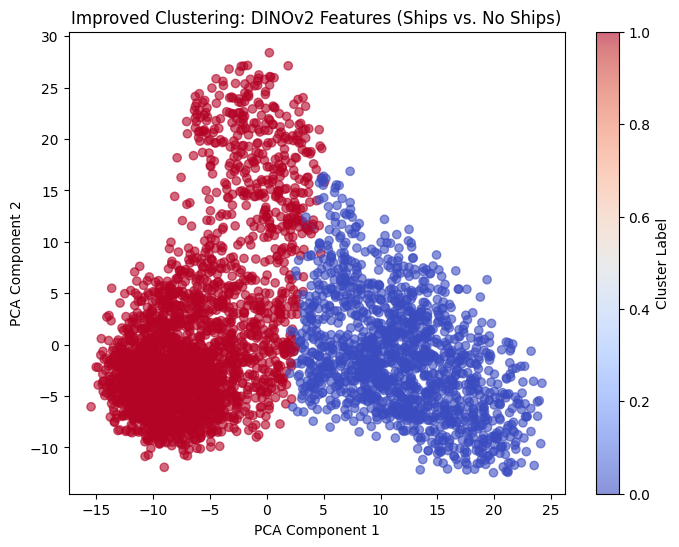

✅ Improved Clustering Accuracy: 60.08%


In [ ]:
# Load extracted features
features = np.load("ship_data/dino_features.npy")
labels = np.load("ship_data/dino_labels.npy")

# Normalize features (important for K-Means)
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Apply K-Means clustering
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(features_scaled)

# Scatter plot of clusters
plt.figure(figsize=(8, 6))
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap="coolwarm", alpha=0.6)
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Improved Clustering: DINOv2 Features (Ships vs. No Ships)")
plt.colorbar(label="Cluster Label")
plt.show()

# Compare clusters with actual labels
accuracy = np.mean(clusters == labels)
print(f"✅ Clustering Accuracy: {accuracy * 100:.2f}%")


### Small Classifier on DINO Features



In [3]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Load features
features = np.load("ship_data/dino_features.npy")
labels = np.load("ship_data/dino_labels.npy")

# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Train SVM classifier
svm = SVC(kernel="linear", C=1.0)
svm.fit(X_train, y_train)

# Predict on test set
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f"✅ SVM Classifier Accuracy: {accuracy * 100:.2f}%")


✅ SVM Classifier Accuracy: 98.62%


SVM learns a better decision boundary than K-Means.
More robust than clustering.

### Applying Ship Detection to Full-Scene Images

🔍 Processing lb_4.png...


Processing Rows: 100%|██████████| 18/18 [02:14<00:00,  7.47s/it]


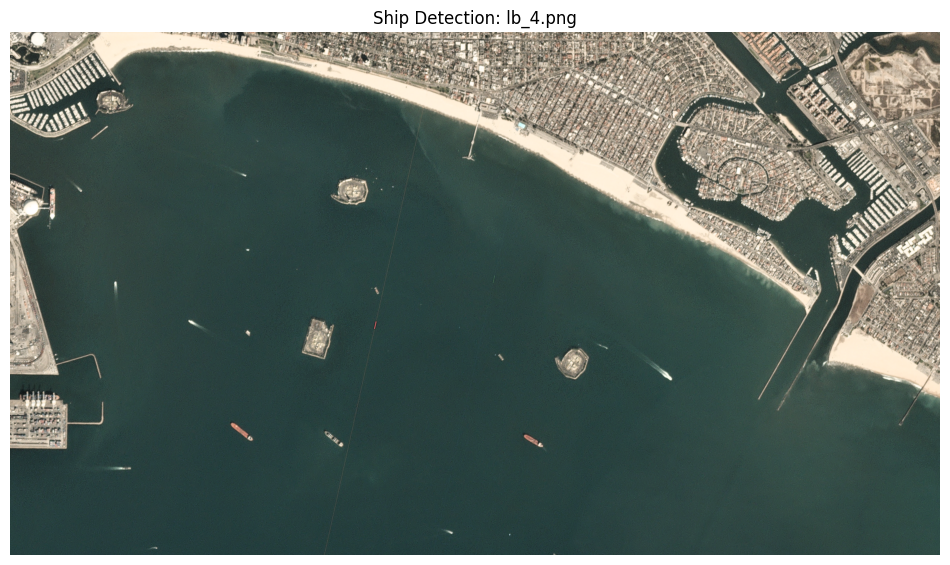

✅ Ship detection completed for all images!


In [ ]:
import os
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt


# Paths
SCENE_DIR = "ship_data/scenes/scenes"  # Folder containing images
MODEL_NAME = "facebook/dinov2-base"

# Load trained SVM model
svm = SVC(kernel="linear", C=1.0)
svm.fit(np.load("ship_data/dino_features.npy"), np.load("ship_data/dino_labels.npy"))

# Load DINOv2 model
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
model = Dinov2Model.from_pretrained(MODEL_NAME)
model.eval()

# Parameters
PATCH_SIZE = 80  # Matches training images
STRIDE = 80  # Overlap for better detection

# Process all scene images
for scene_filename in os.listdir(SCENE_DIR):
    if not scene_filename.endswith(".png"):
        continue

    scene_path = os.path.join(SCENE_DIR, scene_filename)
    scene_image = Image.open(scene_path)
    scene_array = np.array(scene_image)
    height, width, _ = scene_array.shape
    ship_detections = []

    print(f"🔍 Processing {scene_filename}...")

    # Sliding window across image
    for y in tqdm(range(0, height - PATCH_SIZE, STRIDE), desc="Processing Rows"):
        for x in range(0, width - PATCH_SIZE, STRIDE):
            # Extract patch
            patch = scene_array[y:y+PATCH_SIZE, x:x+PATCH_SIZE, :]
            patch_image = Image.fromarray(patch)

            # Extract DINO features
            inputs = processor(patch_image, return_tensors="pt")
            with torch.no_grad():
                features = model(**inputs).last_hidden_state.mean(dim=1).squeeze().numpy()

            # Normalize features
            features_scaled = StandardScaler().fit_transform(features.reshape(1, -1))

            # Predict ship presence
            prediction = svm.predict(features_scaled)[0]

            # If ship detected, store bounding box
            if prediction == 1:
                ship_detections.append((x, y, x + PATCH_SIZE, y + PATCH_SIZE))

    # Draw bounding boxes
    for (x1, y1, x2, y2) in ship_detections:
        cv2.rectangle(scene_array, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue boxes

    # Show and save the result
    plt.figure(figsize=(12, 12))
    plt.imshow(scene_array)
    plt.title(f"Ship Detection: {scene_filename}")
    plt.axis("off")
    plt.show()

    output_path = os.path.join(SCENE_DIR, f"detection_{scene_filename}")
    Image.fromarray(scene_array).save(output_path)
    break

print("✅ Ship detection completed for all images!")


Conclusion: Dino Features didn't work in this kind of images.

## 2nd Try: Using SAM

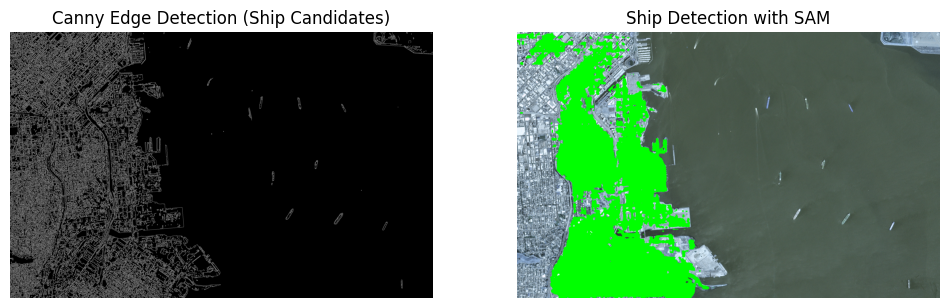

✅ SAM-based ship detection completed!


In [ ]:


# Load SAM model 
sam_checkpoint = "sam_vit_b.pth"  # Ensure you have this file and the correct path
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
predictor = SamPredictor(sam)

# Load full-scene image
SCENE_IMAGE_PATH = "ship_data/scenes/scenes/sfbay_1.png"
scene_image = cv2.imread(SCENE_IMAGE_PATH)
scene_image_rgb = cv2.cvtColor(scene_image, cv2.COLOR_BGR2RGB)

# Convert image to grayscale
gray = cv2.cvtColor(scene_image_rgb, cv2.COLOR_RGB2GRAY)

# Apply Canny Edge Detection to find ship candidates
edges = cv2.Canny(gray, 100, 200)  # Adjust thresholds if needed

# Find contours (possible ship locations)
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
ship_points = np.array([cv2.boundingRect(c)[:2] for c in contours])  # Extract (x, y) coordinates

# Select top 5 detected ship candidates
if len(ship_points) > 5:
    ship_points = ship_points[:5]

# Define background points (random locations in water for better segmentation)
water_points = np.array([[50, 50], [900, 900], [400, 750]])  # Adjust these if needed

# Combine ships and background points
point_coords = np.vstack([ship_points, water_points])
point_labels = np.array([1] * len(ship_points) + [0] * len(water_points))  # Ships = 1, Water = 0

# Run SAM segmentation
predictor.set_image(scene_image_rgb)
masks, _, _ = predictor.predict(point_coords=point_coords, point_labels=point_labels, multimask_output=True)

# Overlay masks on image
for mask in masks:
    scene_image[mask > 0] = [0, 255, 0]  # Highlight detected ships in green

# Show detected edges
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(edges, cmap="gray")
plt.title("Canny Edge Detection (Ship Candidates)")
plt.axis("off")

# Show result with ship detections
plt.subplot(1, 2, 2)
plt.imshow(scene_image)
plt.title("Ship Detection with SAM")
plt.axis("off")
plt.show()

# Save output image
output_path = "ship_data/scenes/sam_detection_sfbay_1.png"
cv2.imwrite(output_path, scene_image)

print("✅ SAM-based ship detection completed!")


Conclusion: Raw SAM didn't work either.

## 3rd Try: YOLO

In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load YOLOv8 model (pre-trained on COCO)
model = YOLO("yolov8x.pt")  # You can also try yolov8n.pt (smaller) or yolov8m.pt (medium)

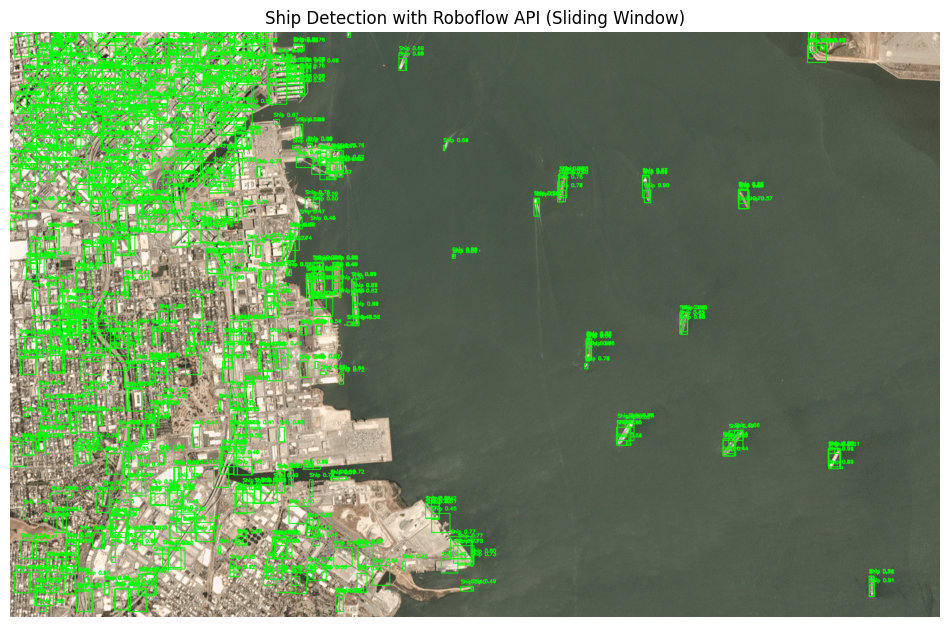

✅ Ship detection using Roboflow API completed!


In [37]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from inference_sdk import InferenceHTTPClient

# Initialize Roboflow Client
CLIENT = InferenceHTTPClient(
    api_url="https://detect.roboflow.com",
    api_key="6Zjga2LB8RntI8puymso"
)

# Load full-scene image
SCENE_IMAGE_PATH = "ship_data/scenes/scenes/sfbay_1.png"
image = cv2.imread(SCENE_IMAGE_PATH)
height, width, _ = image.shape

# Sliding window parameters
PATCH_SIZE = 80
STRIDE = 40
detections = []

# Process image with sliding window
for y in range(0, height - PATCH_SIZE, STRIDE):
    for x in range(0, width - PATCH_SIZE, STRIDE):
        # Extract patch
        patch = image[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

        # Save patch temporarily
        PATCH_PATH = "temp_patch.jpg"
        cv2.imwrite(PATCH_PATH, patch)

        # Run inference on the patch using Roboflow API
        result = CLIENT.infer(PATCH_PATH, model_id="boat-detection-bzj6m/1")

        # Process detections
        for prediction in result["predictions"]:
            x1 = int(prediction["x"] - prediction["width"] / 2) + x
            y1 = int(prediction["y"] - prediction["height"] / 2) + y
            x2 = int(prediction["x"] + prediction["width"] / 2) + x
            y2 = int(prediction["y"] + prediction["height"] / 2) + y
            conf = prediction["confidence"]

            # Only keep detections with confidence > 0.3
            if conf > 0.3:
                detections.append((x1, y1, x2, y2, conf))

# Draw detections on full image
for (x1, y1, x2, y2, conf) in detections:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    cv2.putText(image, f"Ship {conf:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

# Show result
plt.figure(figsize=(12, 12))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Ship Detection with Roboflow API (Sliding Window)")
plt.axis("off")
plt.show()

# Save output image
cv2.imwrite("ship_data/scenes/roboflow_sliding_window_sfbay_1.png", image)

print("✅ Ship detection using Roboflow API completed!")


## 4th Try: YOLO Pre-Trained

In [ ]:
#import YOLO and model from https://huggingface.co/Mahadih534/yolov8_ship_det_satellite/tree/main

from ultralytics import YOLO

model = YOLO('ship.pt')
print(model)

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(64, eps=0.001, momentum=0.03, affine=True, track_running_s


image 1/1 /Users/yass/Desktop/satellite-financial-detection/ship_data/scenes/scenes/sfbay_1.png: 512x768 7 ships, 180.9ms
Speed: 3.0ms preprocess, 180.9ms inference, 0.5ms postprocess per image at shape (1, 3, 512, 768)
Results saved to runs/detect/predict2
Image shape: (1777, 2825, 3)
Image size: 1821.52 KB
Image dimensions: 2825 x 1777


(-0.5, 2824.5, 1776.5, -0.5)

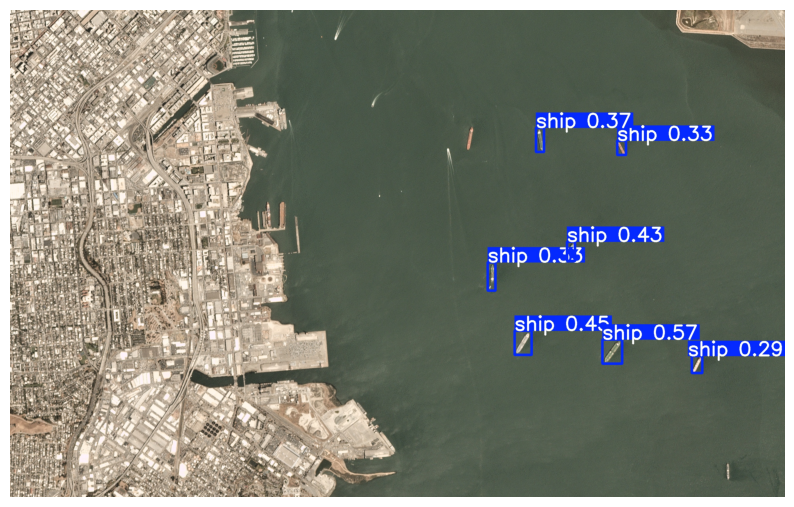

In [14]:
# inference

results = model.predict(source='ship_data/scenes/scenes/sfbay_1.png', conf=0.2, save=True, show=True)

#show results

import cv2
import matplotlib.pyplot as plt
import os
import numpy as np


# Load the image
image_path = './runs/detect/predict/sfbay_1.jpg'

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width, _ = image.shape
print(f"Image shape: {image.shape}")
print(f"Image size: {os.path.getsize(image_path) / 1024:.2f} KB")
print(f"Image dimensions: {width} x {height}")
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis('off')

Conclusion: The pre-trained YOLOv8 model demonstrates significantly higher efficiency in terms of inference speed and computational performance. To quantitatively assess and compare model performance, appropriate evaluation metrics should be utilized. Additionally, the model appears to struggle with detecting boats exhibiting a "bow wave," which may be attributed to limitations in the dataset used during pre-training.